 假设一个大学生正在努力准备期末考试。 
 一个勤奋的学生会努力做好练习，并利用往年的考试题目来测试自己的能力。 尽管如此，在过去的考试题目上取得好成绩并不能保证他会在真正考试时发挥出色。 例如，
 
 学生可能试图通过死记硬背考题的答案来做准备。 他甚至可以完全记住过去考试的答案。  --- 过拟合，强行记忆当前已知的情况
 
 另一名学生可能会通过试图理解给出某些答案的原因来做准备。 ---- 泛化，根据已知处理未知的情况

In [1]:
import math
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

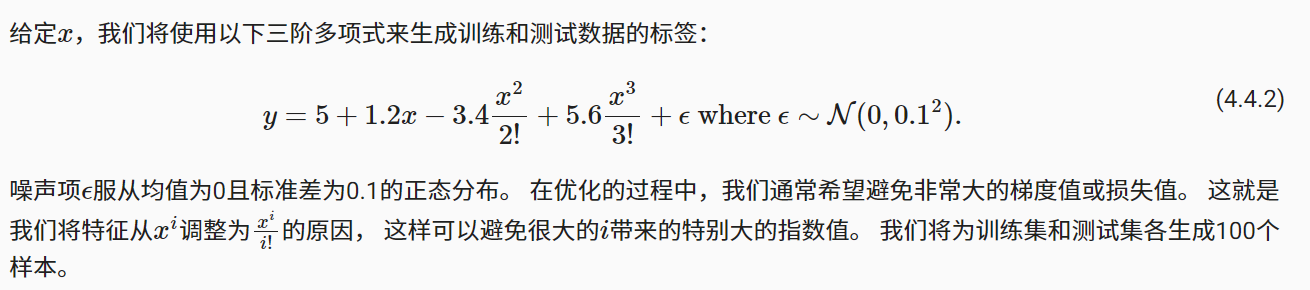

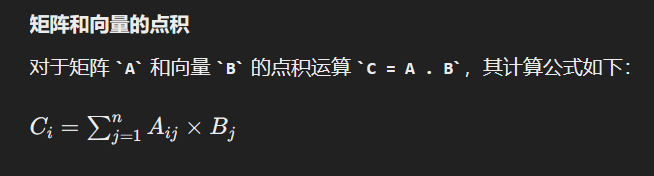

In [12]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

(200, 20) [ 5.   1.2 -3.4  5.6  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0. ]


In [3]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(l.sum(), d2l.size(l))
    return metric[0] / metric[1]

In [4]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # 不设置偏置，因为我们已经在多项式中实现了它
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

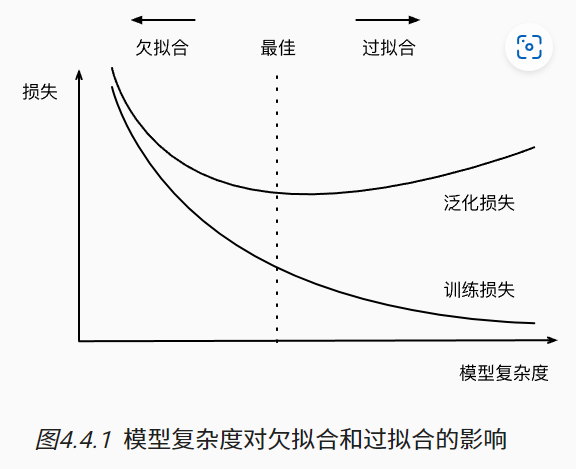

weight: [[ 5.0190597  1.2219312 -3.4237368  5.571771 ]]


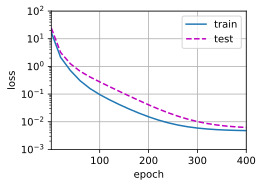

In [5]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.704703  4.2265935]]


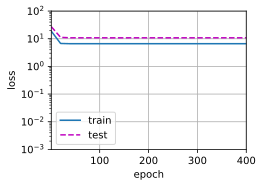

In [6]:
# 从多项式特征中选择前2个维度，即1和x，欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9921474   1.305829   -3.3531876   5.1165934  -0.111081    1.3027778
   0.12696071  0.16642185  0.05133296 -0.02276875  0.00806572 -0.05168008
  -0.0242627  -0.01502217 -0.0494135   0.06389862 -0.04761845 -0.04380166
  -0.05188227  0.05655775]]


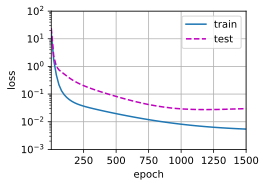

In [7]:
# 从多项式特征中选取所有维度，过拟合
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)